## Segment individual nuclei in a histology image using classical image processing and the Watershed algorithm.

## Import Libraries

In [66]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Load & Visualize

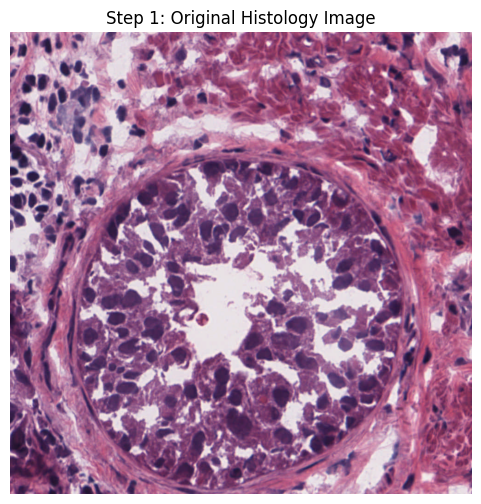

In [69]:
img = cv2.imread('E:\Dataset\MonuSeg-2018\kmms_training\kmms_training\images\TCGA-G2-A2EK-01A-02-TSB.tif')  # Replace with your image path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title('Step 1: Original Histology Image')
plt.axis('off')
plt.show()

## Grayscale Conversion & Gaussian Blur

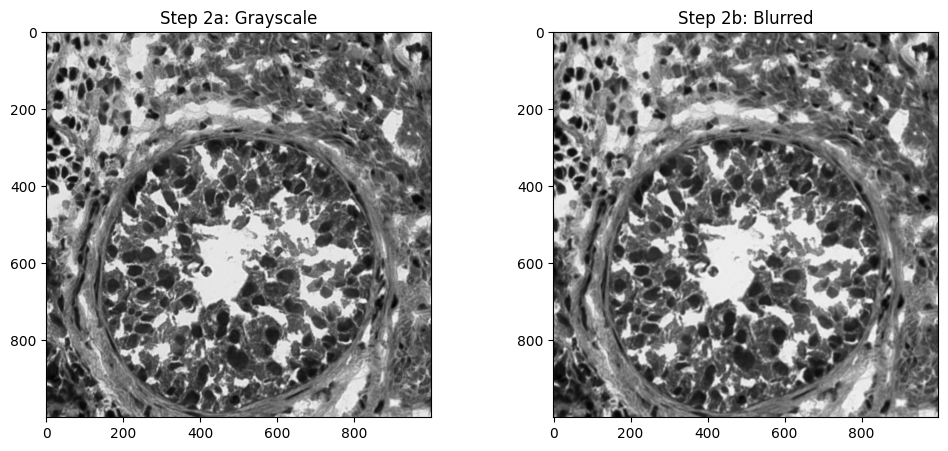

In [71]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1), plt.imshow(gray, cmap='gray'), plt.title('Step 2a: Grayscale')
plt.subplot(1, 2, 2), plt.imshow(blurred, cmap='gray'), plt.title('Step 2b: Blurred')
plt.show()

## Thresholding (Otsu's Binarization)

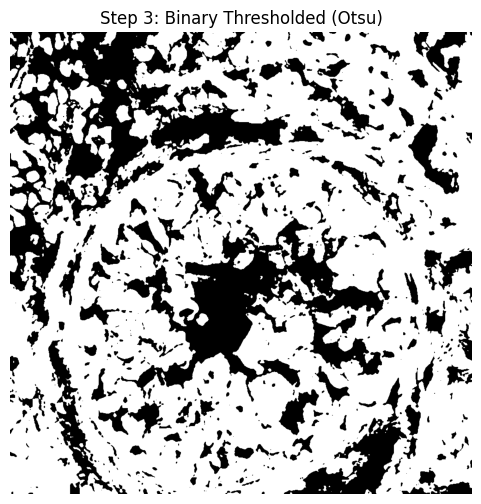

In [73]:
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(6, 6))
plt.imshow(binary, cmap='gray')
plt.title('Step 3: Binary Thresholded (Otsu)')
plt.axis('off')
plt.show()

Visual: Binary image — nuclei in white, background in black (or inverted)

## Morphological Opening & Background

Openning:

Removing small white specks (noise) from a binary image while keeping larger white regions intact.

Background:

"background" often refers to the slowly varying parts of an image (especially in grayscale), such as uneven illumination or shading, that are not part of the foreground objects.

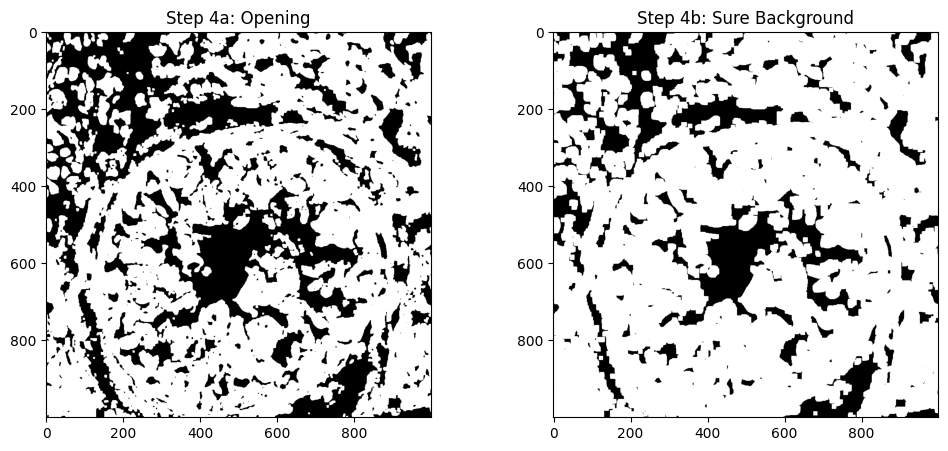

In [20]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1), plt.imshow(opening, cmap='gray'), plt.title('Step 4a: Opening')
plt.subplot(1, 2, 2), plt.imshow(sure_bg, cmap='gray'), plt.title('Step 4b: Sure Background')
plt.show()

Left: Cleaned binary mask

Right: Expanded white regions for background

## Distance Transform & Foreground

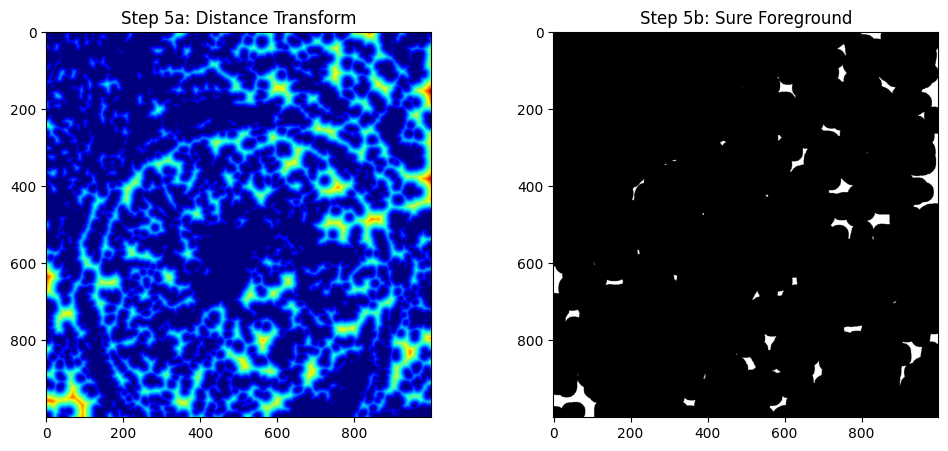

In [24]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1), plt.imshow(dist_transform, cmap='jet'), plt.title('Step 5a: Distance Transform')
plt.subplot(1, 2, 2), plt.imshow(sure_fg, cmap='gray'), plt.title('Step 5b: Sure Foreground')
plt.show()

Left: Distance map — brighter = closer to center

Right: Foreground (likely nuclei centers)

## Unknown Region

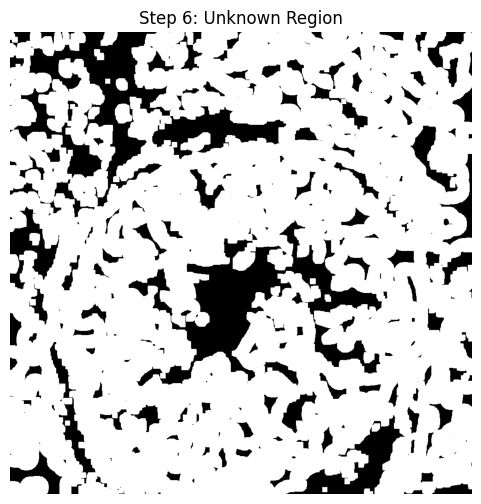

In [75]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(6, 6))
plt.imshow(unknown, cmap='gray')
plt.title('Step 6: Unknown Region')
plt.axis('off')
plt.show()

Visual: Grayscale image highlighting uncertain regions (between cells)

## Marker Labelling

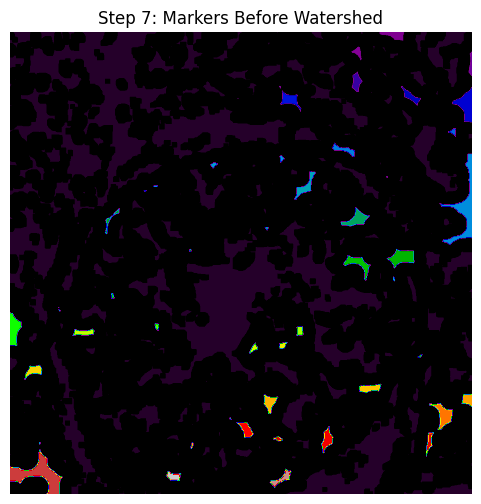

In [77]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # Make background=1
markers[unknown == 255] = 0

plt.figure(figsize=(6, 6))
plt.imshow(markers, cmap='nipy_spectral')
plt.title('Step 7: Markers Before Watershed')
plt.axis('off')
plt.show()

Visual: Each nucleus center is colored differently (label map)

## Apply Watershed Algorithm

In [79]:
# Apply watershed
markers = cv2.watershed(img, markers)

img[markers == -1] = [255, 0, 0]

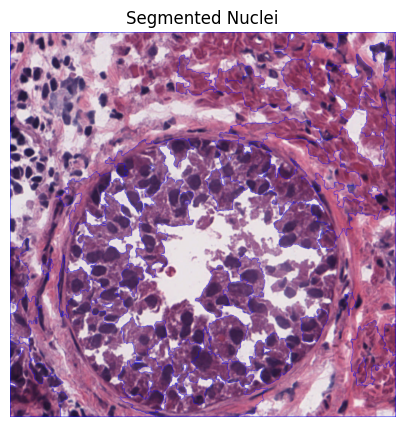

In [81]:
# Display the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Segmented Nuclei')
plt.axis('off')
plt.show()

 Visual: Original image with red boundaries outlining each segmented nucleus

In this project, we used a classical image processing pipeline to accurately segment cell nuclei from histology images using the Watershed algorithm. Here's a brief summary:

1. We preprocessed the image by converting it to grayscale and applying blur to reduce noise.
2. Then, we binarized the image using Otsu’s method to highlight nuclei.
3. Through morphological operations, we separated clear foreground (nuclei centers) from the background.
4. We used distance transform and marker labeling to identify regions for segmentation.
5. Finally, we applied the Watershed algorithm, which drew clear boundaries between overlapping cells.